# Trending Topics de Twitter con Spark Streaming



- Este código no tiene la calidad requerida para sistemas en producción
- El Broker de Twitter (*read.py*) usa la librería *socketstream* y queda a la escucha en un socket TCP (como servidor). El script a su vez está filtrando los tweets provenientes de la Streaming API de Twitter: https://dev.twitter.com/streaming/overview
- A partir de este momento, el broker puede ser ejecutado.

-------------------------------------------------------------------------------------------------------------------

### Dependencias y configuración de contextos

Cargar las librerías para el contexto: de Spark, SQL y Streaming. Así como otras dependencias del ejercicio

In [1]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

from collections import namedtuple
# Namedtuple: https://pymotw.com/2/collections/namedtuple.html, 
# http://stackoverflow.com/questions/2970608/what-are-named-tuples-in-python
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython import display



Crear el contexto de Streaming. Con la configuración: "TwitterTrend" como nombre del programa, 10 segundos como intervalo para batch y dos hilos de ejecución.

De igual manera, crear la instancia del contexto de SQL en Spark.

In [2]:
sc = SparkContext("local[2]", "TwitterTrend")
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)


Una vez instanciados los contextos, nos conectamos a la fuente de datos:

In [3]:
socket_stream = ssc.socketTextStream("localhost", 5555)

### Soporte de Window Operations y tuplas para conteo de etiquetas

Creamos una ventana de tiempo.

El RDD obtenido del DStream se creará cada 10 segundos, pero los datos que estarán en el RDD serán por los últimos 20 segundos.

[Spark Streaming: Window Operations](https://spark.apache.org/docs/latest/streaming-programming-guide.html#window-operations)


![](https://spark.apache.org/docs/latest/img/streaming-dstream-window.png)

In [4]:
lines = socket_stream.window( 20 )

Creamos un objeto namedtuple para almacenar las etiquetas y sus conteos.

In [5]:
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

### Procesar el flujo de datos

1. Cada tweet/mensaje que se recibe, será cortado en palabras (*flatMap()*),
2. Por cada registro generado, se filtrarán  las palabras que empiezan con el simbolo **#**,
3. Después se convertirán esos registros a minúsculas, 
4. Se ejecuta una acción de mapeo a (palabra, 1)
5. Luego, se reducen los pares (llave, valor) y cuentan las ocurrencias de cada Hashtag (palabra, n)
6. El flujo se convierte en un Dataframe con las etiquetas resultantes y sus conteos.
7. Entonces, se ordenan las etiquetas de forma descendente,
8. Y se toman los primeros 10 registos,
9. Finalmente, esos 10 registros se almacenan en una tabla temporal


In [6]:

( lines.flatMap( lambda text: text.split( " " ) )
  .filter( lambda word: word.lower().startswith("#") )
  .map( lambda word: ( word.lower(), 1 ) )
  .reduceByKey( lambda a, b: a + b )
  .map( lambda rec: Tweet( rec[0], rec[1] ) )
  .foreachRDD( lambda rdd: rdd.toDF().sort(desc("count")).limit(10).registerTempTable("tweets") ) )


In [7]:

# Lazy evaluation
ssc.start() 

In [9]:
sqlContext.sql( 'Select tag, count from tweets' ).toPandas()

,tag,count
0,#ico,3
1,#crypto,2
2,#eth,2
3,#btcz,1
4,#exchange…#safein,1
5,#sfn,1
6,#paymentwallet,1
7,#bonus).,1
8,#digitalidentity,1
9,#bthr,1


### Iniciar el proceso de Spark Streaming

### Graficar las tendencias

Podemos cambiar los valores de time.sleep() junto con la operación en ventana de tiempo para actualizaciones más cortas

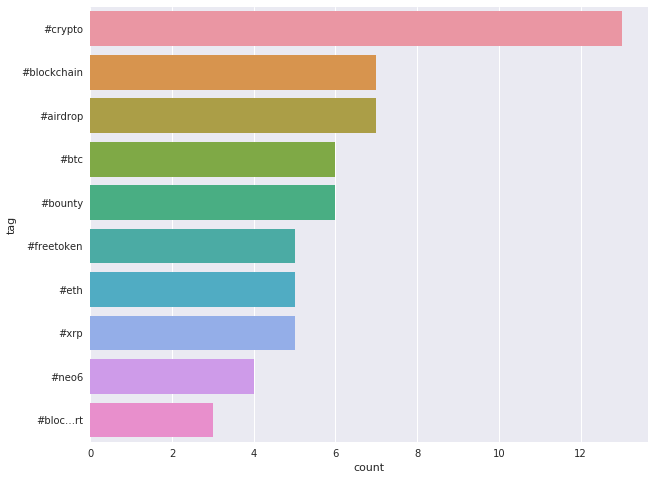

KeyboardInterrupt: 

In [13]:
sns.set()

for i in range(0,1000):
  time.sleep( 2 )
  top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
  top_10_df = top_10_tweets.toPandas()
  display.clear_output(wait=True)
  plt.figure( figsize = ( 10, 8 ) )
  sns.barplot( x="count", y="tag", data=top_10_df)
  plt.show()


In [14]:
ssc.stop()